In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import my_util,my_scaler,read_file,arima
import pyflux as pf
from sklearn.metrics import mean_squared_error

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18,9

/home/zhiyedan/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = read_file.read_aws('art_daily_small_noise.csv')
data = data.to_frame()

diffn,_ = arima.best_diff(data,col='value')
data,diffn_col_name,bck_df = arima.add_diff_col(data,'value',diffn)

train,test = my_util.split_train_test(data,0.7)

order = arima.best_pq(train[diffn_col_name])
aic_order = order.aic_min_order
ar,ma = aic_order[0],aic_order[1]


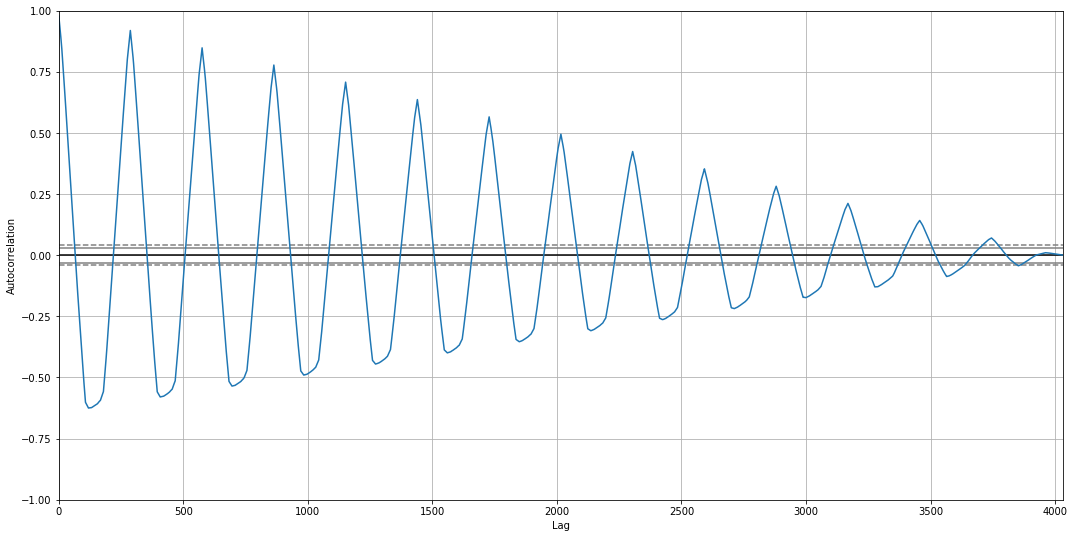

In [6]:
# 自相关
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(data['diff0'])
plt.show()

In [19]:
import statsmodels.api as sm
res = sm.tsa.arma_order_select_ic(
    train['value'], 
    max_ar=8, 
    max_ma=8, 
    ic=['aic', 'bic', 'hqic'], 
    trend='nc'
)

order = list(res.bic_min_order)
order.insert(1,diffn)
print order

[1, 0, 1]


In [34]:
def add_order(min_order,diffn):
    order = list(min_order)
    order.insert(1,diffn)
    return order

orders = [res.aic_min_order,res.bic_min_order,res.hqic_min_order]
orders = map(add_order,orders,[diffn]*len(orders))
orders

In [39]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train['value'], order=order)
model_fit = model.fit(disp=0)
print(model_fit.summary())
model_fit.forecast(1000)

                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                 2822
Model:                     ARMA(1, 1)   Log Likelihood               -8959.675
Method:                       css-mle   S.D. of innovations              5.786
Date:                Thu, 21 Dec 2017   AIC                          17927.349
Time:                        10:37:24   BIC                          17951.130
Sample:                    04-01-2014   HQIC                         17935.930
                         - 04-10-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          41.6622      6.803      6.124      0.000      28.329      54.995
ar.L1.value     0.9889      0.003    354.107      0.000       0.983       0.994
ma.L1.value    -0.2855      0.018    -15.739    

(array([ 24.8409653 ,  25.02781063,  25.21258055,  25.3952981 ,
         25.57598608,  25.75466704,  25.93136327,  26.10609682,
         26.27888948,  26.44976282,  26.61873816,  26.78583657,
         26.9510789 ,  27.11448578,  27.27607759,  27.43587449,
         27.59389641,  27.75016308,  27.90469399,  28.05750843,
         28.20862545,  28.35806391,  28.50584245,  28.65197953,
         28.79649335,  28.93940197,  29.0807232 ,  29.22047469,
         29.35867385,  29.49533795,  29.63048403,  29.76412895,
         29.89628938,  30.02698182,  30.15622257,  30.28402776,
         30.41041333,  30.53539505,  30.65898851,  30.78120914,
         30.90207218,  31.02159271,  31.13978565,  31.25666573,
         31.37224756,  31.48654553,  31.59957393,  31.71134684,
         31.82187821,  31.93118184,  32.03927135,  32.14616025,
         32.25186186,  32.35638936,  32.45975582,  32.56197411,
         32.66305699,  32.76301707,  32.86186684,  32.95961861,
         33.05628459,  33.15187683,  33.

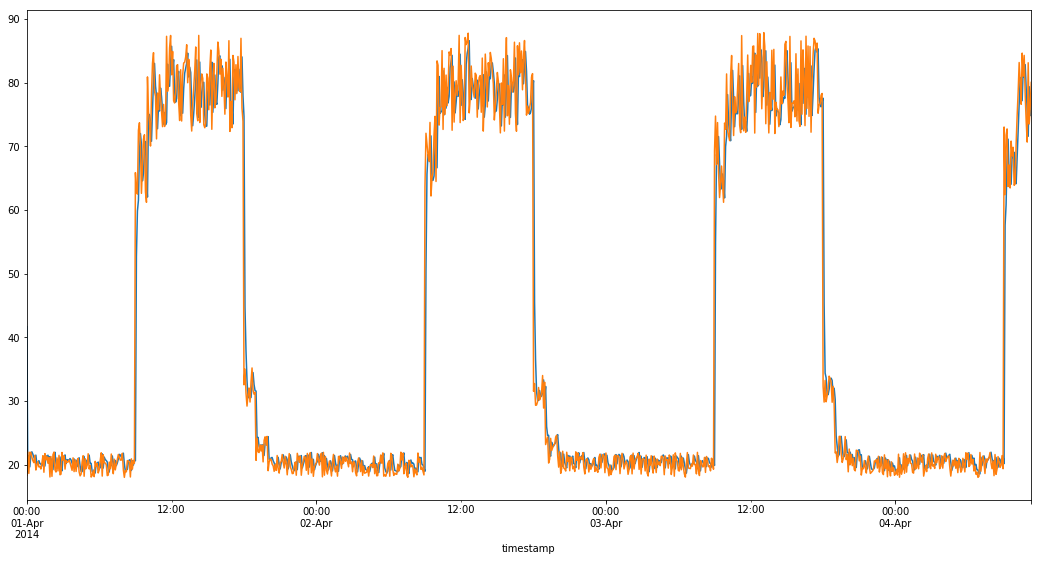

In [42]:
model_fit.fittedvalues[:1000].plot()
train['value'][:1000].plot()
plt.show()

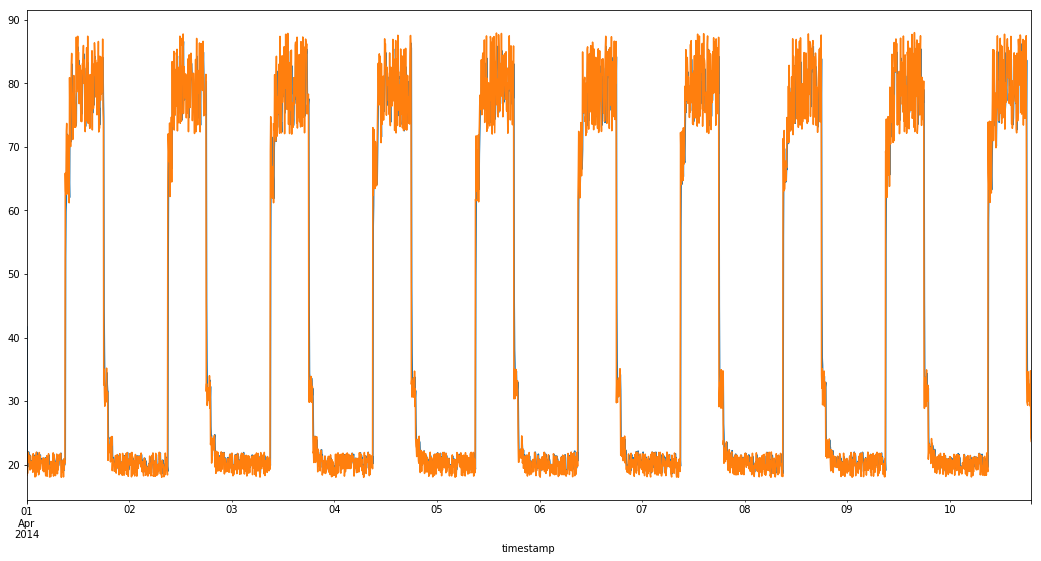

In [46]:
model_fit.predict().plot()
train['value'].plot()
plt.show()

In [60]:
model_fit.forecast(steps=50)[0]

array([ 24.8409653 ,  25.02781063,  25.21258055,  25.3952981 ,
        25.57598608,  25.75466704,  25.93136327,  26.10609682,
        26.27888948,  26.44976282,  26.61873816,  26.78583657,
        26.9510789 ,  27.11448578,  27.27607759,  27.43587449,
        27.59389641,  27.75016308,  27.90469399,  28.05750843,
        28.20862545,  28.35806391,  28.50584245,  28.65197953,
        28.79649335,  28.93940197,  29.0807232 ,  29.22047469,
        29.35867385,  29.49533795,  29.63048403,  29.76412895,
        29.89628938,  30.02698182,  30.15622257,  30.28402776,
        30.41041333,  30.53539505,  30.65898851,  30.78120914,
        30.90207218,  31.02159271,  31.13978565,  31.25666573,
        31.37224756,  31.48654553,  31.59957393,  31.71134684,
        31.82187821,  31.93118184])

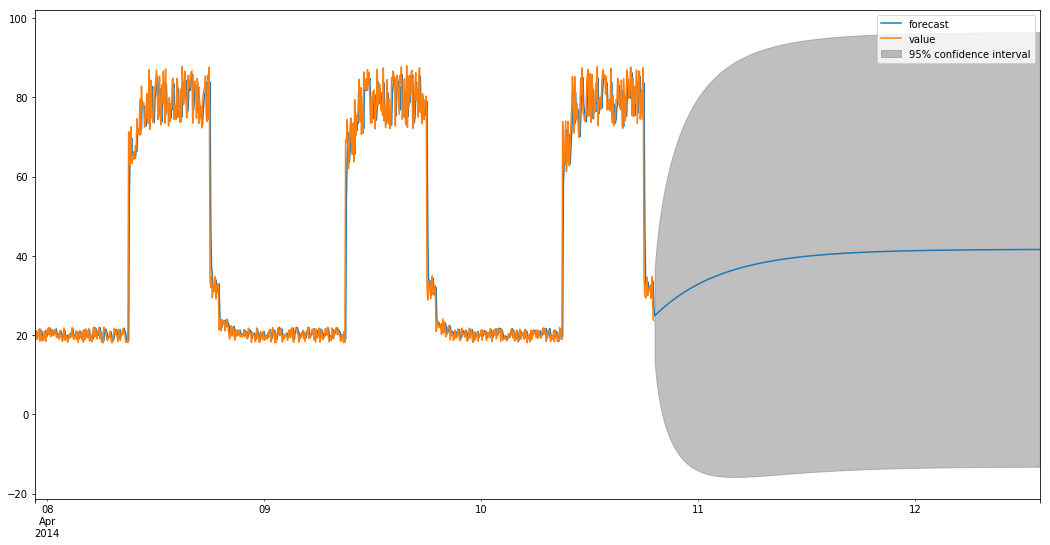

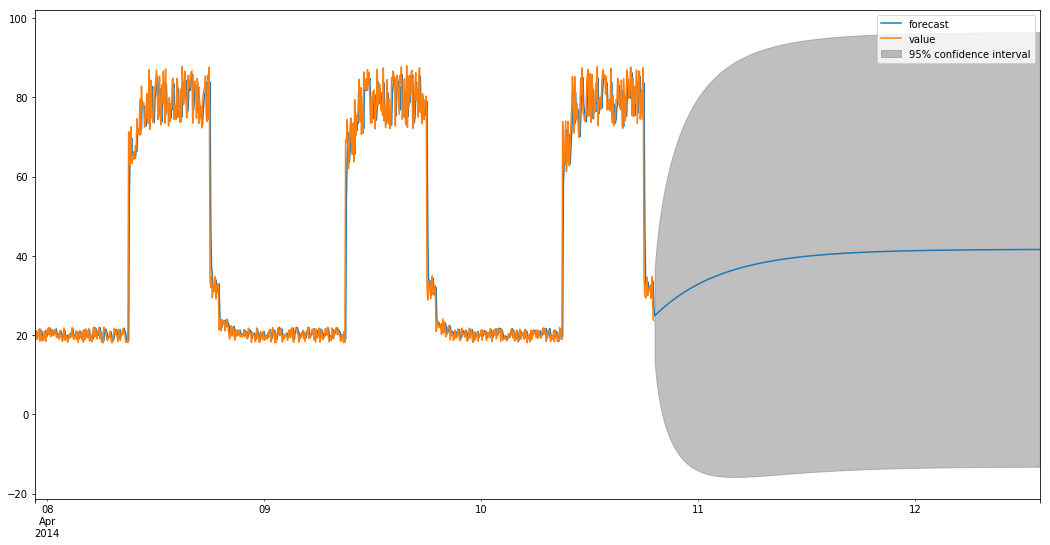

In [70]:
model_fit.plot_predict(start=2000,end=3333)

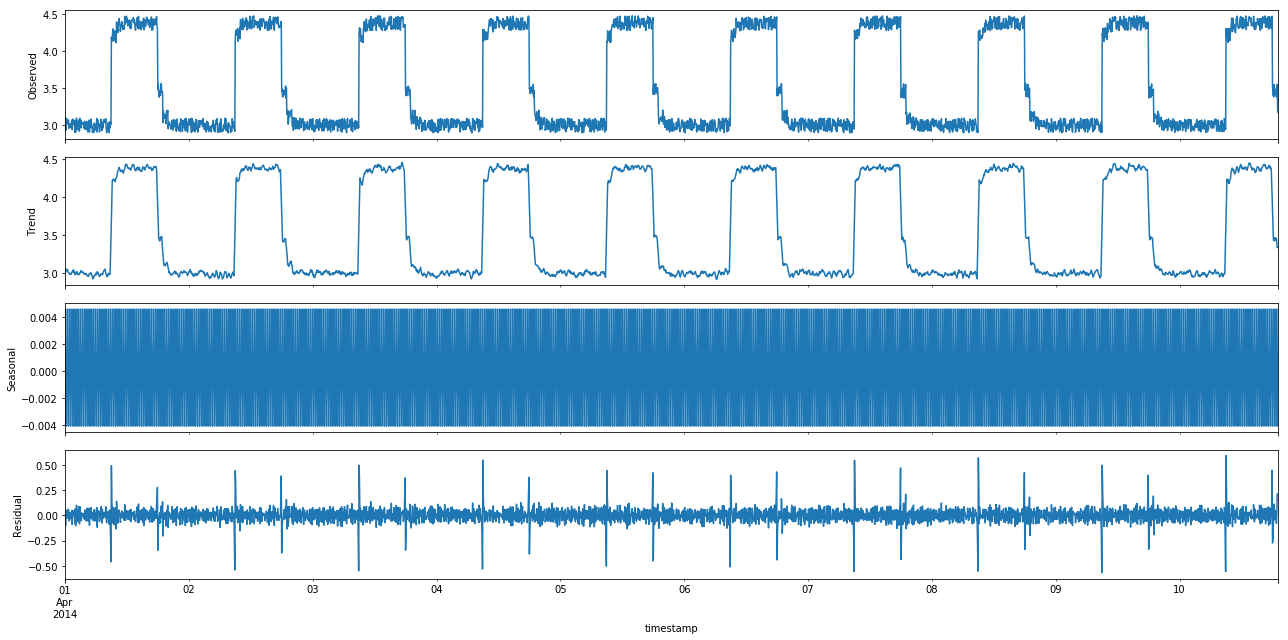

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(train['value']),freq=5,model='additive')
fig = decomposition.plot()
# decomposition.seasonal.plot()
plt.show()

In [122]:
mod = sm.tsa.statespace.(train['value'],
                                order=(1,0,1),
                                seasonal_order=(1,0,1,288),
                               enforce_stationarity=False)
results = mod.fit()
results.summary()

MemoryError: 

In [120]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                 
===========================================================================================
Dep. Variable:                               value   No. Observations:                 2822
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 288)   Log Likelihood               -6677.599
Date:                             Wed, 27 Dec 2017   AIC                          13363.199
Time:                                     09:55:05   BIC                          13386.980
Sample:                                 04-01-2014   HQIC                         13371.780
                                      - 04-10-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0109      0.014     -0.779      0.436      -0.038       0.017
ar.S.L288      1.0003      0.000   3915.124      0.000       1.000       1.001
ma.S.L288     -0.9987      2.523     -0.396      0.692      -5.944       3.947
sigma2         8.8124     22.169      0.398      0.691     -34.638      52.263
===================================================================================
Ljung-Box (Q):                       65.04   Jarque-Bera (JB):               256.55
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.09
Prob(H) (two-sided):                  0.23   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [119]:
train.shape

(2822, 2)

In [118]:
def smooth(df,col,window_num):
    df['smooth'] = np.nan
    for i in range(window_num,df.shape[0]):
        df

IndentationError: expected an indented block (<ipython-input-118-169cf617de4f>, line 3)

In [ ]:
t=linspace(-4,4,100)
x=sin(t)
xn=x+randn(len(t))*0.1
np.smooth(xn)